In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 20 kB/s 
     |████████████████████████████████| 199 kB 54.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=7eaa4b8b14ffa9ed624db35164ea4ac130b3a1862178d7a0a1a045bcf04232ed
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#from elephas.utils.rdd_utils import to_simple_rdd


## Plotting the input variables

Set index to datetime and change the order of columns

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Multifeature Sentiment Analysis

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mainnnnnnn.csv to mainnnnnnn.csv


In [ ]:
df1 = pd.read_csv('mainnnnnnn.csv',header=None)
df1.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price']
df1.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
0,1/1/2020,0.000000,0.945000,0.05500,0.246950,7200
1,1/1/2022,0.082350,0.785500,0.13220,0.115525,47738
2,1/10/2020,0.026937,0.741813,0.16875,0.304075,8187
3,1/10/2022,0.017937,0.896062,0.08600,0.209775,41832
4,1/11/2019,0.000000,0.860000,0.14000,0.381800,3617


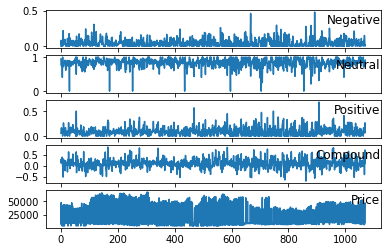

In [ ]:
values = df1.values
# specify columns to plot
groups = [ 1,2,3,4,5]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df1.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [ ]:
df1.set_index('DateTime',inplace=True)

In [ ]:
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
1/1/2020,7200,0.000000,0.945000,0.05500,0.246950
1/1/2022,47738,0.082350,0.785500,0.13220,0.115525
1/10/2020,8187,0.026937,0.741813,0.16875,0.304075
1/10/2022,41832,0.017937,0.896062,0.08600,0.209775
1/11/2019,3617,0.000000,0.860000,0.14000,0.381800


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df1.values)

In [ ]:
n_hours = 3
n_features = 5
n_obs = n_hours*n_features

In [ ]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.059286,0.000000,0.945000,0.079826,0.613305,0.691408,0.171206,0.785500,0.191872,0.528213,0.074676,0.056003,0.741813,0.244920,0.650291,0.599314,0.037292,0.896062,0.124819,0.589236
4,0.691408,0.171206,0.785500,0.191872,0.528213,0.074676,0.056003,0.741813,0.244920,0.650291,0.599314,0.037292,0.896062,0.124819,0.589236,0.003415,0.000000,0.860000,0.203193,0.700615
5,0.074676,0.056003,0.741813,0.244920,0.650291,0.599314,0.037292,0.896062,0.124819,0.589236,0.003415,0.000000,0.860000,0.203193,0.700615,0.072135,0.000000,0.406250,0.136067,0.572612
6,0.599314,0.037292,0.896062,0.124819,0.589236,0.003415,0.000000,0.860000,0.203193,0.700615,0.072135,0.000000,0.406250,0.136067,0.572612,0.501263,0.000000,1.000000,0.000000,0.453415
7,0.003415,0.000000,0.860000,0.203193,0.700615,0.072135,0.000000,0.406250,0.136067,0.572612,0.501263,0.000000,1.000000,0.000000,0.453415,0.613363,0.210098,0.815171,0.080075,0.336346


In [ ]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.059286,0.000000,0.945000,0.079826,0.613305,0.691408,0.171206,0.785500,0.191872,0.528213,0.074676,0.056003,0.741813,0.244920,0.650291,0.599314
4,0.691408,0.171206,0.785500,0.191872,0.528213,0.074676,0.056003,0.741813,0.244920,0.650291,0.599314,0.037292,0.896062,0.124819,0.589236,0.003415
5,0.074676,0.056003,0.741813,0.244920,0.650291,0.599314,0.037292,0.896062,0.124819,0.589236,0.003415,0.000000,0.860000,0.203193,0.700615,0.072135
6,0.599314,0.037292,0.896062,0.124819,0.589236,0.003415,0.000000,0.860000,0.203193,0.700615,0.072135,0.000000,0.406250,0.136067,0.572612,0.501263
7,0.003415,0.000000,0.860000,0.203193,0.700615,0.072135,0.000000,0.406250,0.136067,0.572612,0.501263,0.000000,1.000000,0.000000,0.453415,0.613363


In [ ]:
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(500, 16)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 3, 5) (500,) (568, 3, 5) (568,)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/150
125/125 - 4s - loss: 0.0835 - val_loss: 0.0924 - 4s/epoch - 33ms/step
Epoch 2/150
125/125 - 1s - loss: 0.0710 - val_loss: 0.0849 - 578ms/epoch - 5ms/step
Epoch 3/150
125/125 - 1s - loss: 0.0655 - val_loss: 0.0781 - 586ms/epoch - 5ms/step
Epoch 4/150
125/125 - 1s - loss: 0.0605 - val_loss: 0.0715 - 561ms/epoch - 4ms/step
Epoch 5/150
125/125 - 1s - loss: 0.0551 - val_loss: 0.0645 - 560ms/epoch - 4ms/step
Epoch 6/150
125/125 - 1s - loss: 0.0491 - val_loss: 0.0570 - 592ms/epoch - 5ms/step
Epoch 7/150
125/125 - 0s - loss: 0.0423 - val_loss: 0.0469 - 440ms/epoch - 4ms/step
Epoch 8/150
125/125 - 0s - loss: 0.0340 - val_loss: 0.0374 - 452ms/epoch - 4ms/step
Epoch 9/150
125/125 - 1s - loss: 0.0247 - val_loss: 0.0239 - 558ms/epoch - 4ms/step
Epoch 10/150
125/125 - 1s - loss: 0.0150 - val_loss: 0.0128 - 571ms/epoch - 5ms/step
Epoch 11/150
125/125 - 1s - loss: 0.0095 - val_loss: 0.0097 - 561ms/epoch - 4ms/step
Epoch 12/150
125/125 - 1s - loss: 0.0077 - val_loss: 0.0083 - 567ms/epoch - 

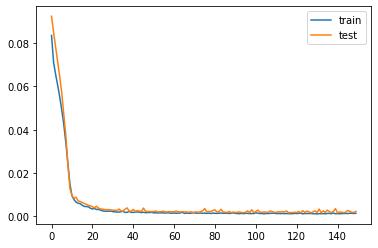

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 440.899


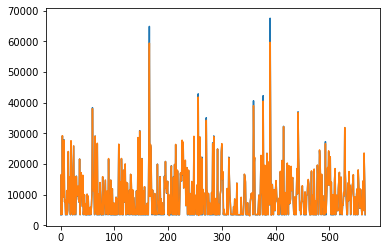

In [ ]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [ ]:
plt.show()

In [ ]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent.csv')